In [3]:
 %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [7]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [11]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables 
Base.prepare(engine,reflect=True)

In [15]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
#set up inspector to get information from the SQLITE engine
myInspector = inspect(engine)
#pulls and lists column names and datatypes for future reference
columns = myInspector.get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [18]:
#pulls and lists column names and datatypes for future reference
columns = myInspector.get_columns("station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Save references to each table
Measurement_Table = Base.classes.measurement
Station_Table = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
mySession = Session(bind=engine)

# Exploratory Climate Analysis

2016-08-23 00:00:00


Text(0, 0.5, 'Inches of Precipitation')

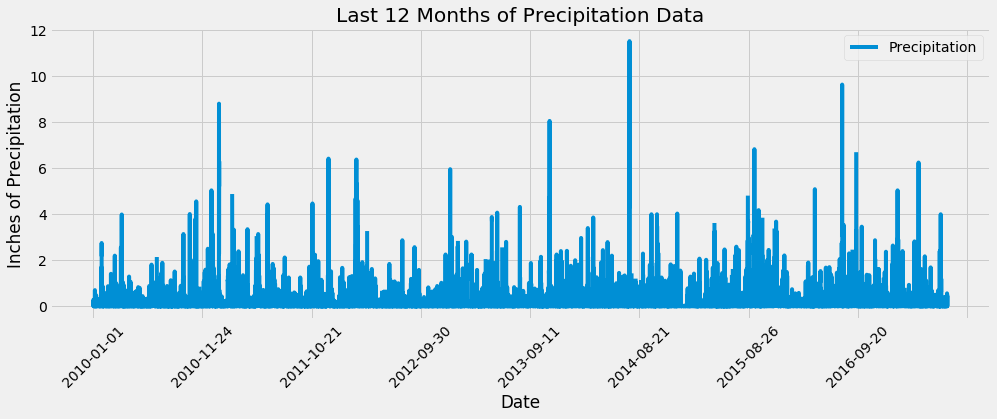

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# since session.query returns a tuple, we use [0][0] to get the value at the first entry
# and datetime.strptime to convert it to a datetime object 
# and subtract a year from it with dt.timedelta
DatePrior12Mo = dt.datetime.strptime(mySession.query(func.max(Measurement_Table.date))[0][0],'%Y-%m-%d') - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
Last12moPrcp = mySession.query(Measurement_Table.prcp, Measurement_Table.date).filter(Measurement_Table.date > DatePrior12Mo)
# Save the query results as a Pandas DataFrame
Last12moPrcp_df = pd.DataFrame(Last12moPrcp)
# Rename columns to capitalize axis labels
Last12moPrcp_df = Last12moPrcp_df.rename(columns = {"date":"Date","prcp":"Precipitation"})
# Sort the dataframe by date
Last12moPrcp_df = Last12moPrcp_df.sort_values(by="Date")
# Set the index to the date column
Last12moPrcp_df = Last12moPrcp_df.set_index("Date")

# Write Database to CSV for access from app.py later
Last12moPrcp_df.to_csv("Resources/Last12moPrcp.csv")

# Use Pandas Plotting with Matplotlib to plot the data
Last12moPrcp_df.plot(rot=45,figsize=(15,5))
plt.title("Last 12 Months of Precipitation Data")
plt.ylabel("Inches of Precipitation")

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Last12moPrcp_df.describe()

,Precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [23]:
# Perform test to verify data set - verifying tobs entry for each dataset
Test_df = pd.DataFrame(mySession.query(func.count(Measurement_Table.station), func.count(Measurement_Table.date),func.count(Measurement_Table.prcp),func.count(Measurement_Table.tobs)),columns=["Station ID","Date","prcp","tobs"])
Test_df

,Station ID,Date,prcp,tobs
0,19550,19550,18103,19550


In [24]:
# Design a query to show how many stations are available in this dataset?
QueryCount = mySession.query(Station_Table.station).count()
print(f"There are a total of {QueryCount} stations available in this dataset.")

There are a total of 9 stations available in this dataset.


In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
StationCounts = mySession.query(Station_Table.station, Station_Table.name, func.count(Measurement_Table.station)).\
    filter(Measurement_Table.station == Station_Table.station).\
    group_by(Measurement_Table.station).\
    order_by(func.count(Measurement_Table.station).desc())
# Assigns tuple to DataFrame for ease of use and cleaner output display
StationCounts_df = pd.DataFrame(StationCounts, columns = ["Station ID","Station Name","Activity Count"])

# Write Database to CSV for access from app.py later
StationCounts_df.to_csv("Resources/StationCounts.csv")

StationCounts_df

,Station ID,Station Name,Activity Count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [26]:
# Using the station id from the previous query
# Pulls first ID directly from tuple since sorted desc
MostActiveStation = StationCounts[0][0] 
# Calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station
MostActiveStationStats = mySession.query(func.min(Measurement_Table.tobs),func.max(Measurement_Table.tobs),func.avg(Measurement_Table.tobs)).\
    filter(Measurement_Table.station == MostActiveStation)
# Assigns tuple to DataFrame for cleaner output display
MostActiveStationStats_df = pd.DataFrame(MostActiveStationStats,columns= ["Lowest Temperature(F)","Highest Temperature(F)","Average Temperature"])
MostActiveStationStats_df

,Lowest Temperature(F),Highest Temperature(F),Average Temperature
0,54.0,85.0,71.663781


Text(0.5, 0, 'Temperature(F)')

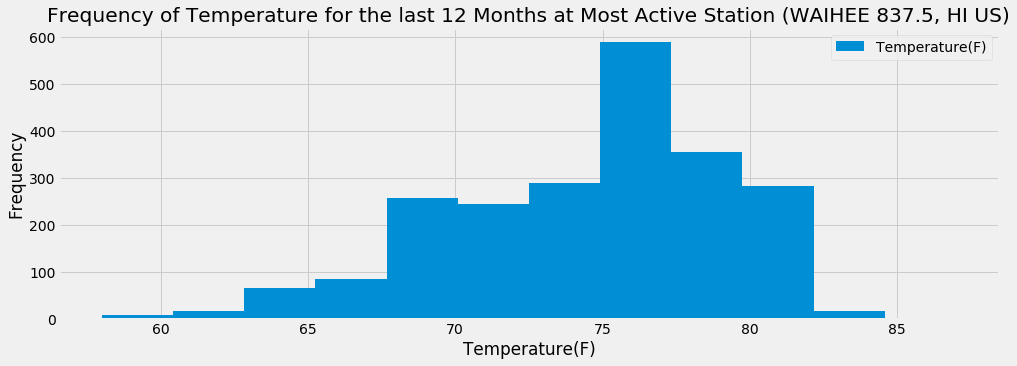

In [41]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
MostActiveStationTemps = mySession.query(Measurement_Table.tobs).\
    filter(Measurement_Table.station == Station_Table.station).filter(Measurement_Table.date > DatePrior12Mo)
# Assigns tuple to DataFrame for cleaner output display    
MostActiveStationTemps_df = pd.DataFrame(MostActiveStationTemps,columns = ["Temperature(F)"])

# Write Database to CSV for access from app.py later
MostActiveStationTemps_df.to_csv("Resources/MostActiveStationTemps.csv")

# Plot the histogram of temperature data with proper title and proper formatting
MostActiveStationTemps_df.plot(kind='hist', bins = 12,figsize=(15,5))
# Pulls first ID directly from tuple
plt.title(f"Frequency of Temperature for the last 12 Months at Most Active Station ({StationCounts[0][1]})")
plt.xlabel("Temperature(F)")

## Bonus Challenge Assignment

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return mySession.query(func.min(Measurement_Table.tobs), func.avg(Measurement_Table.tobs), func.max(Measurement_Table.tobs)).\
        filter(Measurement_Table.date >= start_date).filter(Measurement_Table.date <= end_date).all()
        
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement_Table.tobs), func.avg(Measurement_Table.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement_Table.date) == date).all()
    
daily_normals("01-01")

NameError: name 'Measurement' is not defined

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [35]:
# Plot the daily normals as an area plot with `stacked=False`
